# Reproduction de la technique de détection des lignes sur la route d'après Advance Driver Intention Inference

A l'heure actuelle le problème d'utilisation des filtres orientables provient de la sortie de la convolution 
- là où pour le canny edge les valeurs sont soit 0 soit 255. 
- celles du steerable filters varient entre des valeurs très négatives et des valeurs très positives. 

Le post traitement de steerable filters n'est peut-être pas adapté. Histoire des energies et orientations. 

cluster lines together ? 


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as sc
import cv2
import sys

np.set_printoptions(threshold=sys.maxsize)

## Edge Detection with second order filters

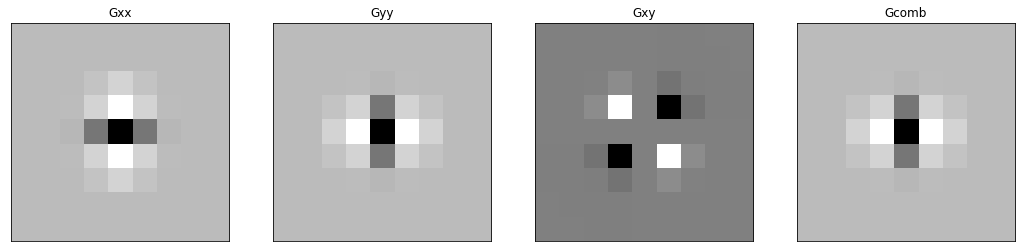

In [2]:
sigma=1.0
theta=-np.pi/2

# filter_size = 2 * int(4 * sigma + 0.5) + 1 # taille du filtre en fonction du sigma recherché 
filter_size = 7 

# Second order filter initialization
Gxx = np.zeros((filter_size, filter_size), np.float32) # création du filtre vide 
Gyy = np.zeros((filter_size, filter_size), np.float32) # création du filtre vide
Gxy = np.zeros((filter_size, filter_size), np.float32) # création du filtre vide
Gcomb = np.zeros((filter_size, filter_size), np.float32) # création du filtre vide
m = filter_size//2
n = filter_size//2
    
for x in range(-m, m+1):
    for y in range(-n, n+1):
        
        # Second order 
        # le filtre est balayé de par le centre d'où la range selon x et selon y 
        Gxx[x+m, y+n] = (4*x**2/sigma**2-2/sigma**2)*np.exp(-(x**2 + y**2)/sigma**2) ## Gxx
        Gyy[x+m, y+n] = (4*y**2/sigma**2-2/sigma**2)*np.exp(-(x**2 + y**2)/sigma**2) ## Gyy
        Gxy[x+m, y+n] = (4*x*y/sigma**2)*np.exp(-(x**2 + y**2)/sigma**2) ## Gxy
        Gcomb[x+m, y+n] = np.cos(theta)**2*Gxx[x+m, y+n] + np.sin(theta)**2*Gyy[x+m, y+n] - 2*np.sin(theta)*np.cos(theta)*Gxy[x+m, y+n]
        
        # Order ??
        # Gcomb[x+m, y+n]= np.cos(theta) * (-2*x) * np.exp(-(x**2 + y**2)/sigma**2) + np.sin(theta) * (-2*y) * np.exp(-(x**2 + y**2)/sigma**2)
        
plt.figure(figsize=(18, 8)) 
plt.subplot(141),
plt.imshow(Gxx, cmap='gray')
plt.title('Gxx'), plt.xticks([]), plt.yticks([])
plt.subplot(142),
plt.imshow(Gyy, cmap='gray')
plt.title('Gyy'), plt.xticks([]), plt.yticks([])
plt.subplot(143),
plt.imshow(Gxy, cmap='gray')
plt.title('Gxy'), plt.xticks([]), plt.yticks([])
plt.subplot(144),
plt.imshow(Gcomb, cmap='gray')
plt.title('Gcomb'), plt.xticks([]), plt.yticks([])

plt.show()

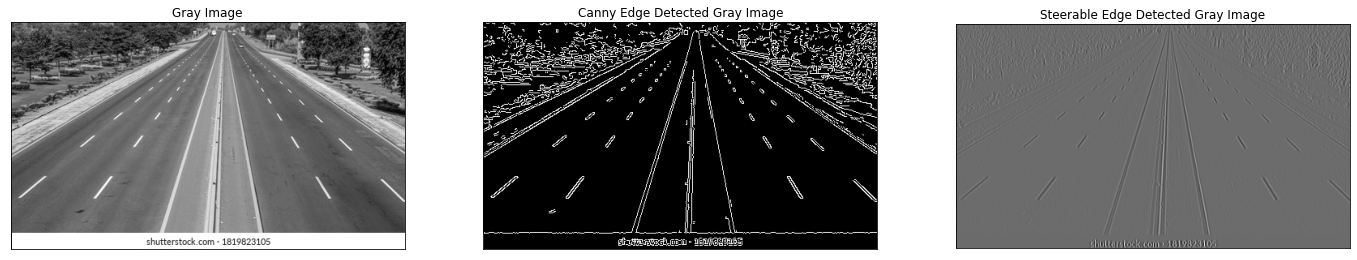

In [3]:
import scipy.signal as signal

img = cv2.imread('HL.jpg')
#img = cv2.imread('catenaire.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

grad_extra = signal.convolve2d(gray, Gcomb, mode='valid')#, boundary='fill')

low_threshold, high_threshold = [200, 300]
grad = cv2.Canny(gray, low_threshold, high_threshold)

plt.figure(figsize=(24, 8)) 
plt.subplot(131),
plt.imshow(gray,cmap = 'gray')
plt.title('Gray Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),
plt.imshow(grad,cmap = 'gray')
plt.title('Canny Edge Detected Gray Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),
plt.imshow(grad_extra,cmap = 'gray')
plt.title('Steerable Edge Detected Gray Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [4]:
print('Image size = {}'.format(img.shape))
print('Gray size = {}'.format(gray.shape))
print('Edge Detection size = {}'.format(grad.shape))

Image size = (280, 486, 3)
Gray size = (280, 486)
Edge Detection size = (280, 486)


## Crop to new dimensions 

## Define a Region of Interest 

In [5]:
# import cv2
import imutils
# import numpy as np
# import joblib
 
pts = [] # for storing points
 
 
 # :mouse callback function
def draw_roi(event, x, y, flags, param):
    img2 = img.copy()
 
    if event == cv2.EVENT_LBUTTONDOWN: # Left click, select point
        pts.append((x, y))  
 
    if event == cv2.EVENT_RBUTTONDOWN: # Right click to cancel the last selected point
        pts.pop()  
 
    if event == cv2.EVENT_MBUTTONDOWN: # 
        mask = np.zeros(img.shape, np.uint8)
        points = np.array(pts, np.int32)
        points = points.reshape((-1, 1, 2))
                 # 
        mask = cv2.polylines(mask, [points], True, (255, 255, 255), 2)
        mask2 = cv2.fillPoly(mask.copy(), [points], (255, 255, 255)) # for ROI
        mask3 = cv2.fillPoly(mask.copy(), [points], (0, 255, 0)) # for displaying images on the desktop
 
        show_image = cv2.addWeighted(src1=img, alpha=0.8, src2=mask3, beta=0.2, gamma=0)
 
        cv2.imshow("mask", mask2)
        cv2.imshow("show_img", show_image)
 
        ROI = cv2.bitwise_and(mask2, img)
        cv2.imshow("ROI", ROI)
        cv2.waitKey(0)
 
    if len(pts) > 0:
                 # Draw the last point in pts
        cv2.circle(img2, pts[-1], 3, (0, 0, 255), -1)
 
    if len(pts) > 1:
                 # 
        for i in range(len(pts) - 1):
            cv2.circle(img2, pts[i], 5, (0, 0, 255), -1) # x ,y is the coordinates of the mouse click place
            cv2.line(img=img2, pt1=pts[i], pt2=pts[i + 1], color=(255, 0, 0), thickness=2)
 
    cv2.imshow('image', img2)
 
 
 #Create images and windows and bind windows to callback functions
# img = cv2.imread('HL.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = imutils.resize(img, width=500)
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw_roi)
print("[INFO] Click the left button: select the point, right click: delete the last selected point, click the middle button: determine the ROI area")
print("[INFO] Press ‘S’ to determine the selection area and save it")
print("[INFO] Press ESC to quit")
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break
    if key == ord("s"):
        saved_data = pts
        #joblib.dump(value=saved_data, filename="config.pkl")
        #print("[INFO] ROI coordinates have been saved to local.")
        print(saved_data)
        break
cv2.destroyAllWindows()
#saved_data = [(4, 165), (221, 34), (245, 10), (282, 10), (303, 37), (484, 162), (479, 258), (5, 258), (6, 167)]
# source https://www.programmersought.com/article/3449903953/

[INFO] Click the left button: select the point, right click: delete the last selected point, click the middle button: determine the ROI area
[INFO] Press ‘S’ to determine the selection area and save it
[INFO] Press ESC to quit
[(7, 172), (230, 29), (296, 27), (484, 166), (482, 254), (2, 256), (5, 177)]


In [6]:
# Setting the corners of the trapezium
#vertices = np.array([[(0, img_line.shape[0]), (img_line.shape[1], img_line.shape[0]), (400, 260), (600, 260)]])

# make a blank/white image
mask = np.zeros_like(gray)
mask_channels = (255,) * img.shape[2]

# Fill the area of interest with 0 and 255 these
# which lie outside of it, thoughout all color channels
cv2.fillPoly(mask, [np.array(saved_data)], mask_channels)

print('Image size = {}'.format(img.shape))
print('Gray size = {}'.format(gray.shape))
print('Grad size = {}'.format(grad.shape))
print('Mask size = {}'.format(mask.shape))

# Keep only the pixels with 0 value of the canny_img
# remplace la ROI1 dans l'image 1 par la ROI2 dans l'image 2 en utilisant le masque
# seule possibilité pour avoir un résultat potable 
# https://docs.opencv.org/master/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14 pour plus d'infos 
masked_grad = cv2.bitwise_and(grad, grad, mask=mask)

# source https://towardsdatascience.com/line-detection-make-an-autonomous-car-see-road-lines-e3ed984952c

Image size = (280, 486, 3)
Gray size = (280, 486)
Grad size = (280, 486)
Mask size = (280, 486)


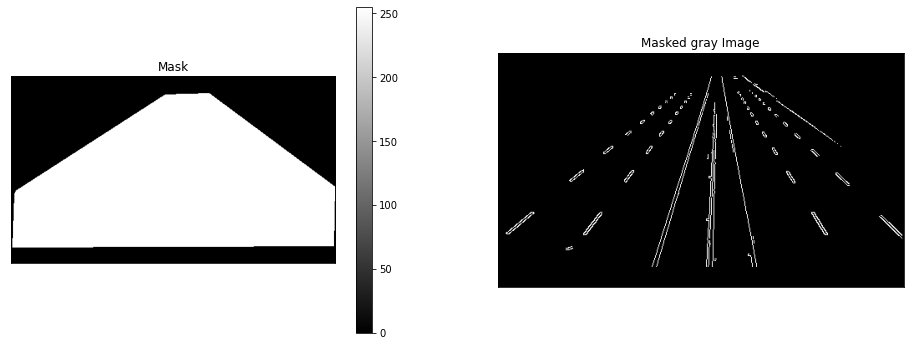

In [7]:
plt.figure(figsize=(16, 6)) 
plt.subplot(121),
plt.imshow(mask, cmap='gray')
plt.colorbar()
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(122),
plt.imshow(masked_grad ,cmap = 'gray')
plt.title('Masked gray Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
print(np.amin(grad))
print(np.amax(grad))

0
255


In [9]:
cv2.imwrite('test.jpg', masked_grad)
grad = cv2.imread('test.jpg', 0)

## Lines Aggregation with Hough Transform

(21, 1, 4)


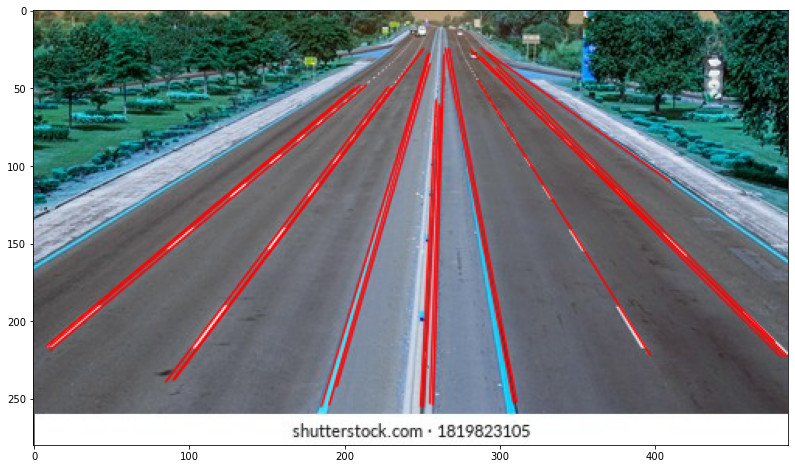

In [10]:
lines = cv2.HoughLinesP(image=grad, rho=1, theta=np.pi/180, threshold=100, lines=np.array([]),minLineLength=100, maxLineGap=80)

# Opencv
# rho : The resolution of the parameter r in pixels. FIXED
# theta: The resolution of the parameter θ in radians. FIXED
# threshold: The minimum number of intersections to "*detect*" a line
# minLineLength: The minimum number of points that can form a line. 
    # Lines with less than this number of points are disregarded.
# maxLineGap: The maximum gap between two points to be considered in the same line.

a,b,c = lines.shape
print(lines.shape)
for i in range(a):
    l = lines[i][0]
    cv2.line(img, (l[0], l[1]), (l[2], l[3]), (255,0,0), 1, cv2.LINE_AA)
    # cv2.imwrite('houghlines4.jpg', img)
plt.figure(figsize=(16, 8)) 
plt.imshow(img)
plt.show()

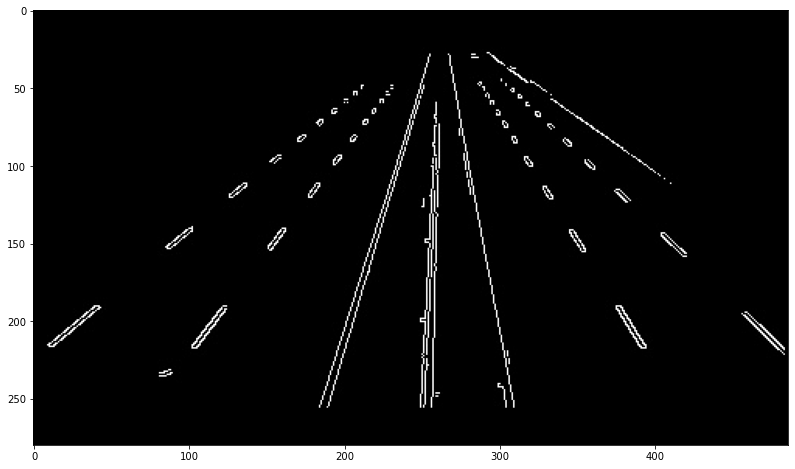

In [11]:
plt.figure(figsize=(16,8))
plt.imshow(grad,cmap = 'gray')
plt.show()

In [12]:
cv2.imwrite('HL_masked.jpg', grad)

True

In [15]:
from sklearn.cluster import KMeans

In [23]:
kmeans = KMeans(n_clusters=8).fit(lines_new)
y_kmeans = kmeans.predict(lines_new)

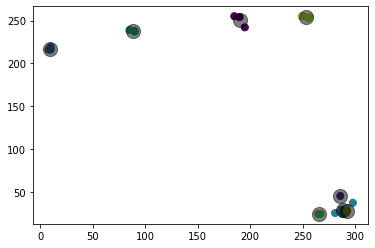

In [24]:
plt.scatter(lines_new[:, 0], lines_new[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [19]:
lines_new = np.reshape(lines, (21,4) )

In [18]:
lines.shape

(21, 1, 4)

In [25]:
lines_new

array([[249, 255, 259,  57],
       [190, 254, 255,  27],
       [251, 255, 261,  60],
       [265,  24, 309, 253],
       [298,  37, 484, 223],
       [185, 255, 254,  28],
       [ 10, 219, 214,  48],
       [195, 242, 255,  34],
       [287,  29, 481, 223],
       [255, 253, 262,  62],
       [257, 254, 264,  28],
       [ 90, 238, 251,  24],
       [288,  24, 477, 213],
       [ 90, 237, 231,  49],
       [267,  24, 311, 252],
       [  8, 216, 206,  50],
       [281,  25, 485, 222],
       [292,  27, 410, 110],
       [ 10, 216, 210,  48],
       [ 85, 239, 228,  49],
       [286,  45, 397, 222]], dtype=int32)

In [27]:
lines_new[:,0]

array([249, 190, 251, 265, 298, 185,  10, 195, 287, 255, 257,  90, 288,
        90, 267,   8, 281, 292,  10,  85, 286], dtype=int32)